In [2]:
import import_ipynb
import datetime
import pandas
from numpy import nan
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import dates as mdate
from IPython.display import Image
#pandas.options.display.float_format = '{:,.3f}'.format

# Soil moisture level shift detection
### brainstorm
* Reliable soil moisture sensor
 * cluster
* Interesting in moisture changes level instead of level itself
* Noise enviroment
 * apply moving average
 * change level threshold
 * moisture probes might not be installed in the same way
 * worm might be near to the probes
 * root might be near to the probes
 * noise is natural in analogic devices
* Monitoring sudden soil moisture sensors changes caused by:
 * rain (negative change level)
 * irrigation (negative change level)
 * hard sun (positive change level)
 * manual interventions (positive change level)
 * system malfuction (positive or negative change level)
* Linear regression
 * know moisture trends: positive alpha is expected
 * score evaluates alpha
* consider multiples sensors
 * consensus/voting?
 * sensor might not be sync
  * delays between change levels
  * time proximity

### referencies
* https://centre-borelli.github.io/ruptures-docs/
* https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/
* https://charles.doffy.net/files/sp-review-2020.pdf
* http://www.laurentoudre.fr/publis/TOG-SP-19.pdf

## Test location
* LATITUDE: -22.019989
* LONGITUDE: -47.312531
![title](./img/maps_location.png)

![title](./img/oasis_test_moisture.png)

## Hardware
* ESP8266
* Raspberry Pi 3B

![title](./img/moisture_schematics.png)

# Data flow
* Every 30 seconds ESP8266 collects and sends sensors data to the Raspberry Pi
* Communication between ESP8266 and Raspberry Pi happens over a private wifi network, using MQTT protocol.

In [3]:
# CONSTANTS

MOISTURES_PROBES = ['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']
ROLLING_WINDOW = 30 # RUPTURE_LEVEL_THRESHOLD and PCT_CHANGE_PERIOD are affected by this value
RUPTURE_LEVEL_THRESHOLD = 0.015
PCT_CHANGE_PERIOD = 10 # RUPTURE_LEVEL_THRESHOLD is affected by this value 

# UTILS

def plot(series): 
    plt.rcParams['figure.figsize'] = [15,7]
    plt.rcParams['timezone'] = 'America/Sao_Paulo'

    fig,ax = plt.subplots()
    x = mdate.epoch2num(series.index)
    fmt = mdate.DateFormatter('%y-%m-%d %H:%M')

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks( rotation=25 )
    plt.plot_date(x, series, linestyle='solid', marker='None')
    plt.legend(MOISTURES_PROBES)
    plt.show()

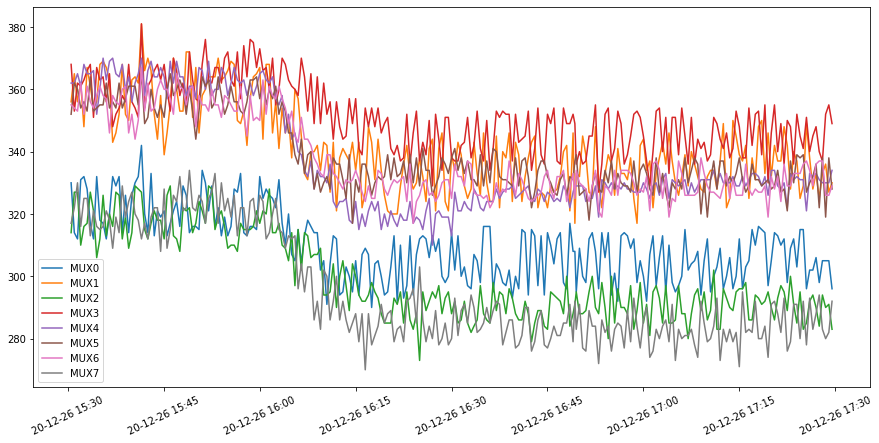

In [4]:
# RAW DATA FROM 2020-12-26 15:30 TO 2020-12-26 17:30
df = pandas.read_pickle('./detect_sudden_change_dataset.pkl')
plot(df)

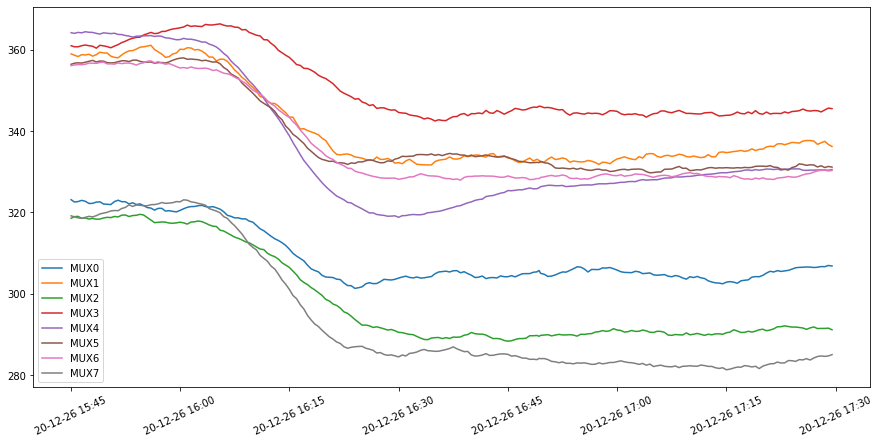

In [5]:
# Filtering the noise ...
dfr = df.rolling(ROLLING_WINDOW).mean().dropna()
plot(dfr)

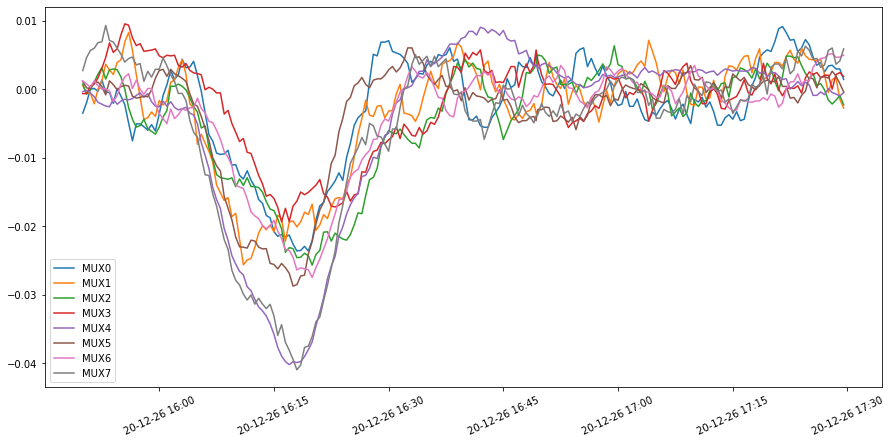

In [6]:
#Percentage change between the current and a prior element
# Finding negative or positive slopes ...
# percent change over given number of period.
pct_change_series = dfr.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
plot(pct_change_series)

In [10]:
def detect_rupture(data):
    #Percentage change between the current and a prior element
    # Finding negative or positive slopes ...
    # percent change over given number of period.
    pct_change_series = data.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
    ### Gathering data
    ruptures={}
    min_probes={}
    max_probes={}
    for mux in MOISTURES_PROBES:
        min_entry={}
        min_entry['epoch'] = pct_change_series[mux].idxmin()
        min_entry['timestamp'] = datetime.datetime.fromtimestamp(min_entry['epoch']).strftime('%Y-%m-%d %H:%M:%S')
        min_entry['value'] = pct_change_series[mux][min_entry['epoch']]
        if min_entry['value'] < -RUPTURE_LEVEL_THRESHOLD:
            min_probes[mux] = min_entry

        max_entry={}
        max_entry['epoch'] = pct_change_series[mux].idxmax()
        max_entry['timestamp'] = datetime.datetime.fromtimestamp(max_entry['epoch']).strftime('%Y-%m-%d %H:%M:%S')
        max_entry['value'] = pct_change_series[mux][max_entry['epoch']]
        if max_entry['value'] > RUPTURE_LEVEL_THRESHOLD:
            max_probes[mux] = max_entry
    ruptures['downward'] = pandas.DataFrame(data=min_probes).T
    ruptures['upward'] =  pandas.DataFrame(data=max_probes).T
    return ruptures


ruptures = detect_rupture(dfr)

In [11]:
ruptures['downward']

,epoch,timestamp,value
MUX0,1609010370,2020-12-26 16:19:30,-0.0236212
MUX1,1609009860,2020-12-26 16:11:00,-0.0256339
MUX2,1609010400,2020-12-26 16:20:00,-0.0256689
MUX3,1609010160,2020-12-26 16:16:00,-0.0193578
MUX4,1609010220,2020-12-26 16:17:00,-0.0401923
MUX5,1609010250,2020-12-26 16:17:30,-0.0287367
MUX6,1609010400,2020-12-26 16:20:00,-0.0274757
MUX7,1609010280,2020-12-26 16:18:00,-0.0409497


In [12]:
ruptures['upward']

""


# DARK SKY forecast weather log (2020-12-26)


URL: https://api.darksky.net/forecast/[key]/-22.019989,-47.312531,1609007400?units=si&lang=pt&exclude=currently,flags,daily


https://api.darksky.net/forecast/[key]/-22.019989,-47.312531,1609007400?units=si&lang=pt&exclude=currently,flags,daily


In [4]:
hourly_forecast = pandas.read_pickle('./detect_sudden_change_darksky_dataset.pkl')

In [6]:
start_time = 1608998400 # 1PM
#rupture estimate time: 1609010280 ~4PM
end_time   = 1609020000 # 7PM
hourly_forecast[(hourly_forecast.index > start_time) & (hourly_forecast.index < end_time)]

,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
time,,,,,,,,,,,,,,,,,
1609002000,Possível Chuva Fraca,rain,0.8592,0.29,rain,27.05,28.90,21.01,0.70,1009.5,2.66,4.22,33,0.60,8,10.965,266.5
1609005600,Possível Chuva Fraca,rain,0.4373,0.32,rain,25.93,26.50,20.85,0.74,1009.0,1.85,3.74,40,0.56,6,10.791,266.5
1609009200,Possível Chuva Fraca,rain,0.5623,0.33,rain,25.08,25.75,21.52,0.81,1008.6,2.38,3.24,70,0.62,4,10.682,266.7
1609012800,Chuva,rain,1.7220,0.48,rain,24.37,25.15,22.18,0.88,1008.8,2.37,4.79,55,0.64,1,4.678,266.5
1609016400,Chuva,rain,1.4671,0.47,rain,24.15,24.93,22.17,0.89,1009.0,2.38,4.22,60,0.65,0,5.618,266.3
